In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tkl
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, RandomContrast
from tensorflow.keras.models import Sequential


In [2]:
with zipfile.ZipFile('/content/alpaca.zip','r') as zip_ref:
  zip_ref.extractall('/content/')

<h1>Importing Image and Label</h1>

In [3]:
path ='/content/dataset'
img_data = []
label=[]
for fol_name in os.listdir(path):
  for image in os.listdir(path+'/'+fol_name):
    img = cv2.imread(path+'/'+fol_name+'/'+image)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    img = img/255.0
    img_data.append(img)
    if fol_name == 'alpaca':
      label.append(0)
    else:
      label.append(1)

In [4]:
# fomal way of data injection for iamge dataset
#for now i wont be using this one as I have already done this part and dataset is not that big

'''
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = path
    ,validation_split = 0.2
    ,subset = 'training'
    ,label_mode = 'binary'
    ,image_size = (224,224)
    ,batch_size = 32
    ,shuffle = True
    ,seed = 42
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = path
    ,validation_split = 0.2
    ,subset = 'validation'
    ,label_mode = 'binary'
    ,image_size = (224,224)
    ,batch_size = 32
    ,shuffle = True
    ,seed = 42
)
'''

"\ntrain_dataset = tf.keras.utils.image_dataset_from_directory(\n    directory = path\n    ,validation_split = 0.2\n    ,subset = 'training'\n    ,label_mode = 'binary'\n    ,image_size = (224,224)\n    ,batch_size = 32\n    ,shuffle = True\n    ,seed = 42\n)\ntest_dataset = tf.keras.utils.image_dataset_from_directory(\n    directory = path\n    ,validation_split = 0.2\n    ,subset = 'validation'\n    ,label_mode = 'binary'\n    ,image_size = (224,224)\n    ,batch_size = 32\n    ,shuffle = True\n    ,seed = 42\n)\n"

In [5]:
img_data = np.array(img_data)
label = np.array(label)

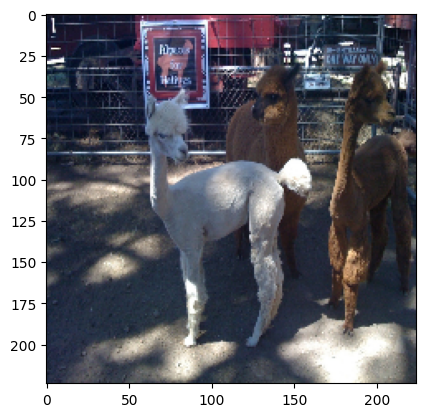

In [6]:
plt.imshow(img_data[0])
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(img_data,label,test_size=0.2,random_state=42)

In [8]:
y_train[0]

np.int64(1)

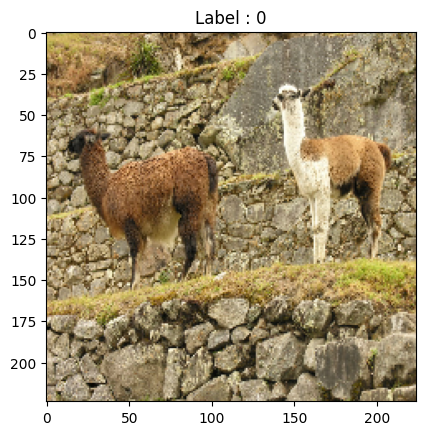

In [9]:
plt.imshow(X_train[12])
plt.title(f'Label : {y_train[12]}')
plt.show()

<h1>Image Agumentation</h1>

In [10]:
def img_augment():
  data_augmentation = Sequential([
      RandomFlip("horizontal_and_vertical"),
      RandomRotation(0.2),
      RandomZoom(0.2),
      RandomContrast(0.2)
  ])
  return data_augmentation

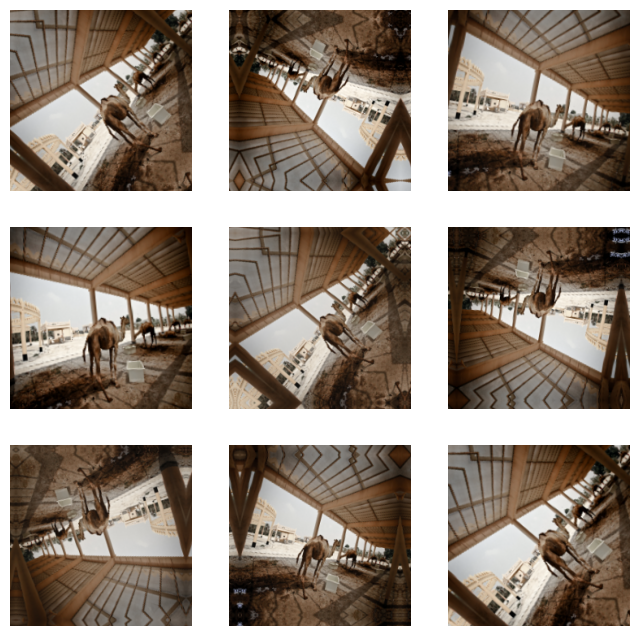

In [11]:
plt.figure(figsize=(8,8))
for i in range(9):
  augmented_img = img_augment()(tf.expand_dims(X_train[0],0))
  plt.subplot(3,3,i+1)
  plt.imshow(augmented_img[0])
  plt.axis('off')
plt.show()

In [12]:
data_shape = X_train[0].shape
data_shape

(224, 224, 3)

In [13]:
mobile_net_model = tf.keras.applications.MobileNetV2(
    input_shape = data_shape,
    weights = 'imagenet',
    include_top = True #addFC layer
)

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<h1>Model Summary</h1>

In [14]:
mobile_net_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

last two layer are called top laeyrs very important for prediction


okay so for this pipeline we need Xtest and ytest in same dataset

In [15]:
autotune = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)) #combines
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)) #combines
#seting batch and prefetch
train_dataset = train_dataset.batch(32)\
                             .prefetch(buffer_size=autotune) #preloads next batch in parallel with training (for speed)
test_dataset = test_dataset.batch(32)\
                           .prefetch(buffer_size=autotune)

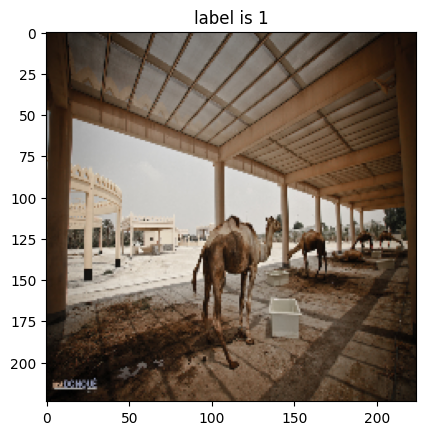

In [16]:
batch_1 = train_dataset.take(1)
img_batch1, label_batch1 = next(iter(batch_1))
plt.imshow(img_batch1[0])
plt.title(f'label is {label_batch1[0]}')
plt.show()

Training the batch 1

In [17]:
tf.atan

<function tensorflow.python.ops.gen_math_ops.atan(x: typing.Annotated[_any, ~TV_Atan_T], name=None) -> typing.Annotated[_any, ~TV_Atan_T]>

In [18]:
#preprocess input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
mobile_net_model.trainable = False
batch_1_preprocess = preprocess_input(img_batch1)
pred = mobile_net_model(batch_1_preprocess,training=False)

<h1>Customizing which layer to be trainable<h1>

In [20]:
def alpaca_model(input_shape, data_augmentation = img_augment()):
  #importing model and frezzing layers
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,include_top = False,weights='imagenet')
  base_model.trainable = False

  #input laeyr
  inputs = tf.keras.Input(shape=input_shape)
  #augmentation
  X = data_augmentation(inputs)
  #preprocessing
  X = preprocess_input(X)

  #training
  X = base_model(X,training=False)
  #now we adding global avg pooling and dense laeyr with dropout
  X = tf.keras.layers.GlobalAveragePooling2D()(X)
  X = tf.keras.layers.Dropout(0.2)(X)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(X)

  model = tf.keras.Model(inputs,outputs)
  return model

In [21]:
model = alpaca_model(input_shape=data_shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00014),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [23]:
history_1 = model.fit(train_dataset,epochs=10,validation_data=test_dataset)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.5241 - loss: 0.7036 - val_accuracy: 0.5303 - val_loss: 0.6883
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6459 - loss: 0.6691 - val_accuracy: 0.5455 - val_loss: 0.6885
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5186 - loss: 0.7083 - val_accuracy: 0.5455 - val_loss: 0.6890
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5432 - loss: 0.6947 - val_accuracy: 0.5455 - val_loss: 0.6891
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5155 - loss: 0.7180 - val_accuracy: 0.5455 - val_loss: 0.6886
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5001 - loss: 0.7400 - val_accuracy: 0.5455 - val_loss: 0.6880
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4790 - loss: 0.7228 - val_accuracy: 0.5455 - val_loss: 0.6879
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5582 - loss: 0.6803 - val_accuracy: 0.5455 - val_loss: 0.68

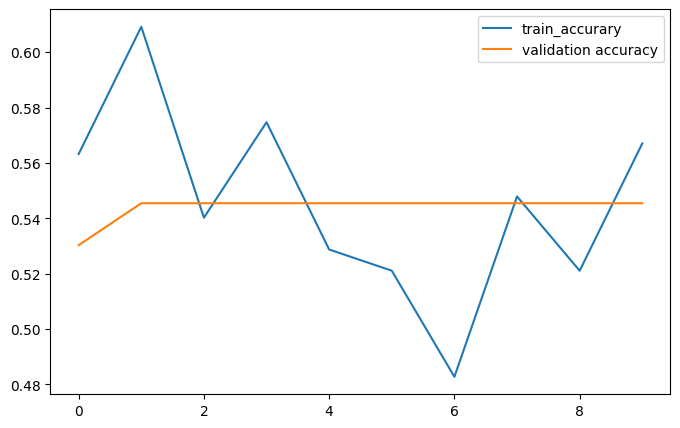

In [24]:
plt.figure(figsize=(8,5))
plt.plot(history_1.history['accuracy'],label='train_accurary')
plt.plot(history_1.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()

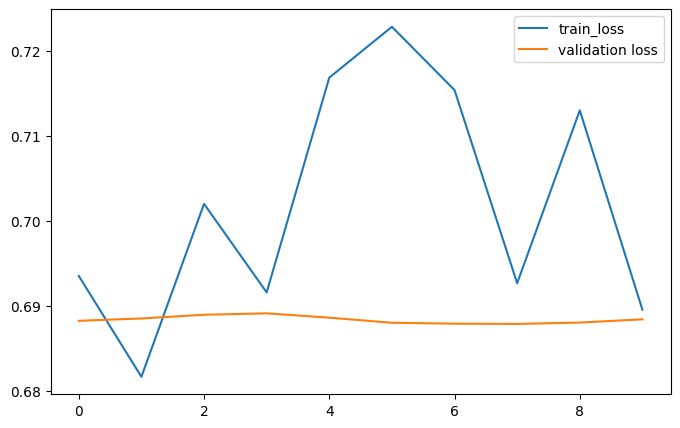

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history_1.history['loss'],label='train_loss')
plt.plot(history_1.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

In [26]:
len(model.layers)

6

<h1>Selecting second layer from model and setting sublayer of 2nd layer as trainable after 100th sublayer<h1>

In [27]:
# we will be making few layers in submodel trianable
base_model= model.layers[2]
base_model.trainable = True
len(base_model.layers)

154

In [28]:
#lets make every layer after 100 trainable
for layer in base_model.layers[:100]:
  layer.trainable = False

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00014),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [30]:
history_2 = model.fit(train_dataset,epochs=10,validation_data=test_dataset)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.5045 - loss: 0.7348 - val_accuracy: 0.5455 - val_loss: 0.7021
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5753 - loss: 0.7044 - val_accuracy: 0.4545 - val_loss: 0.7122
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5081 - loss: 0.7145 - val_accuracy: 0.5455 - val_loss: 0.8398
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5727 - loss: 0.6793 - val_accuracy: 0.5455 - val_loss: 0.7223
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5764 - loss: 0.6715 - val_accuracy: 0.4545 - val_loss: 0.6945
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6298 - loss: 0.6626 - val_accuracy: 0.4545 - val_loss: 0.7212
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6126 - loss: 0.6516 - val_accuracy: 0.5455 - val_loss: 0.6896
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6021 - loss: 0.6925 - val_accuracy: 0.5455 - val_loss

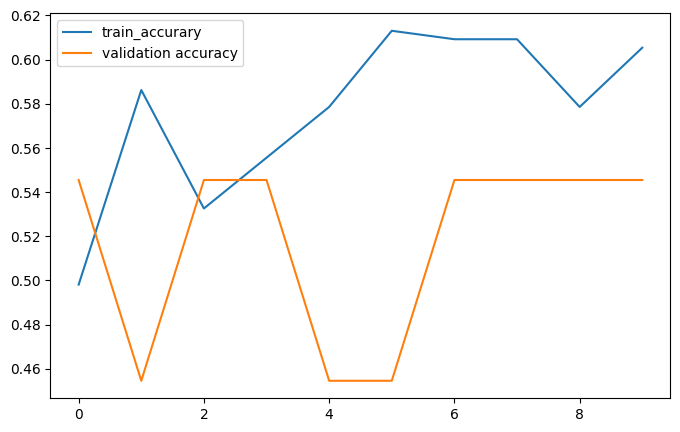

In [31]:
plt.figure(figsize=(8,5))
plt.plot(history_2.history['accuracy'],label='train_accurary')
plt.plot(history_2.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()

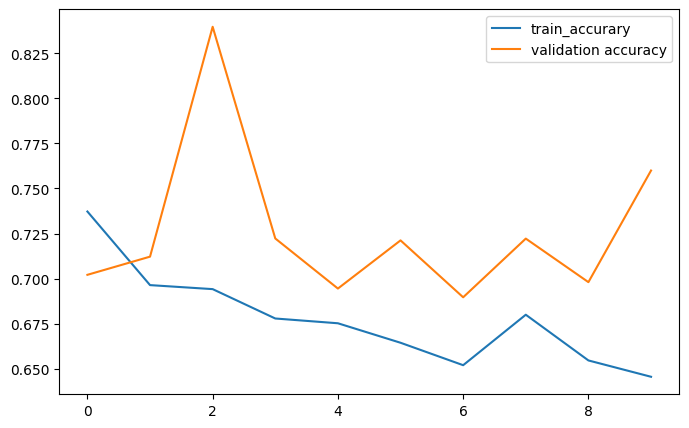

In [32]:
plt.figure(figsize=(8,5))
plt.plot(history_2.history['loss'],label='train_accurary')
plt.plot(history_2.history['val_loss'],label='validation accuracy')
plt.legend()
plt.show()